# **1. Data Exploration**

## **1.1 Inner & Outer LSOA**

**LSOA Boundary**

In [1]:
import geopandas as gpd

lsoa_path = 'Data/GIS/LSOA/LSOA_2011_London_gen_MHW.shp'
lsoa = gpd.read_file(lsoa_path)
lsoa = lsoa.to_crs(epsg=27700)

print("New CRS:", lsoa.crs)

New CRS: EPSG:27700


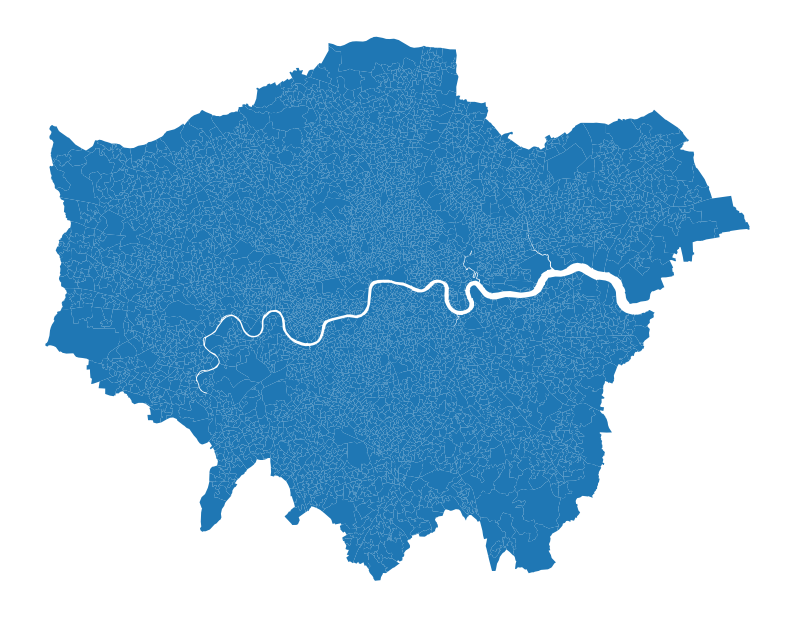

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
lsoa.plot(ax=ax)
ax.set_axis_off()
plt.show()

**CAZ**

In [2]:
!pip install --upgrade shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 6.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6


In [6]:
caz = gpd.read_file('Data/GIS/CAZ/Central_Activities_Zone.gpkg')
print("Original CRS:", caz.crs)

caz = caz.to_crs(epsg=27700)
print("New CRS:", caz.crs)

Original CRS: PROJCS["unnamed",GEOGCS["Airy 1830",DATUM["unknown",SPHEROID["airy",6377563.396,299.324975315035],EXTENSION["PROJ4_GRIDS","Q:\Temp\yw\ostn02-ntv2-data\OSTN02_NTv2.gsb"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.999601],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
New CRS: EPSG:27700


<Axes: >

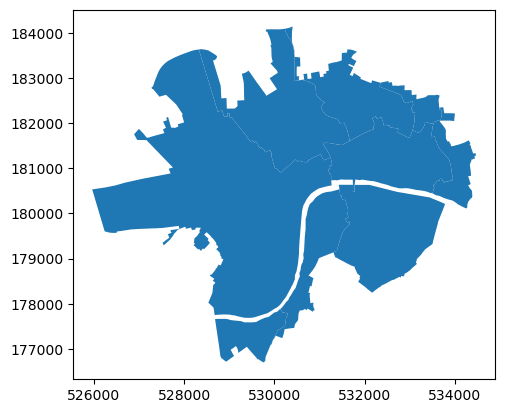

In [7]:
caz.plot()

**Overlapping**

/tmp/ipykernel_154/2856937601.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


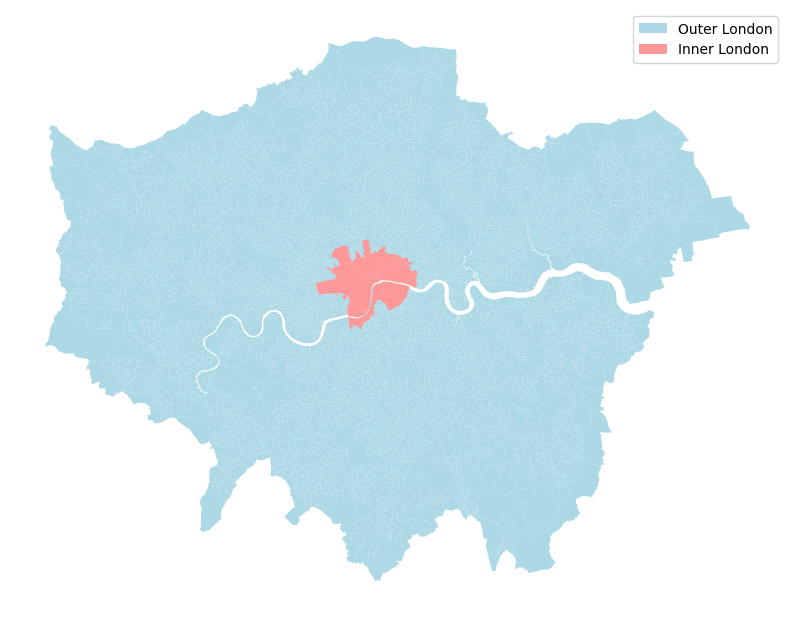

In [10]:
caz["label"] = "Inner London"
lsoa["label"] = "Outer London"

fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, color='#add8e6', linewidth=0, label='Outer London')
caz.plot(ax=ax, color='#ff9999', linewidth=0, edgecolor='black', label='Inner London')

ax.axis('off')
ax.legend()

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#add8e6', label='Outer London'),
    Patch(facecolor='#ff9999', label='Inner London')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.show()

In [11]:
from shapely.geometry import Point

lsoa = lsoa.to_crs(caz.crs)
lsoa_centroids = lsoa.geometry.centroid

# Combine all CAZ polygons into a single geometry
caz_union = caz.unary_union

# Create the new boolean column: 1 if centroid is within CAZ, else 0
lsoa["inner_outer"] = lsoa_centroids.within(caz_union).astype(int)

/tmp/ipykernel_154/1580072623.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  caz_union = caz.unary_union


In [12]:
lsoa.head()

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,label,inner_outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.23, 532162.491 181...",Outer London,1
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18...",Outer London,1
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.25 182...",Outer London,1
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.77, 533649.063 180...",Outer London,1
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18...",Outer London,0


## **1.2 Tube Stations**

In [13]:
stations = gpd.read_file('Data/GIS/TfL/tfl_stations.json')

In [14]:
stations = stations.to_crs(epsg = 27700)

In [15]:
import re

station_names = {row.id: row['name'] for i, row in stations.iterrows()}

for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)
    
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name
    
stations['name'] = stations['id'].apply(lambda x: station_names[x])
cleaned_name_map = stations.set_index('id')['name'].to_dict()

In [16]:
stations

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry
0,940GZZLUACT,Acton Town,0500,"[ { ""name"": ""District"" }, { ""name"": ""Piccadill...","{ ""labelX"": 30 }",None,1,None,3,POINT (519483.347 179591.968)
1,940GZZLUACY,Archway,0508,"[ { ""name"": ""Northern"", ""nightopened"": 2016 } ]","{ ""labelX"": -30 }",None,8,None,2/3,POINT (529380.63 186814.054)
2,940GZZLUADE,Aldgate East,0503,"[ { ""name"": ""District"" }, { ""name"": ""Hammersmi...","{ ""labelX"": 30 }",None,3,None,1,POINT (533885.038 181342.159)
3,940GZZLUAGL,Angel,0507,"[ { ""name"": ""Northern"" }, { ""name"": ""Crossrail...","{ ""labelX"": 1, ""labelY"": -35 }",None,7,None,1,POINT (531460.461 183134.266)
4,940GZZLUALD,Aldgate,0502,"[ { ""name"": ""Circle"" }, { ""name"": ""Metropolita...","{ ""labelX"": 25, ""labelY"": 20 }",None,2,None,1,POINT (533621.756 181218.291)
...,...,...,...,...,...,...,...,...,...,...
524,910GWNSTDPK,Wanstead Park,7408,"[ { ""name"": ""London Overground"", ""opened"": 200...","{ ""labelX"": 1, ""labelY"": -45 }",None,None,None,3,POINT (540586.481 185590.993)
525,910GWOLWXR,Woolwich,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 25, ""labelY"": -20 }",None,None,None,4,POINT (543858.406 179015.443)
526,910GWRCSTRP,Worcester Park,5579,"[ { ""name"": ""National Rail"", ""opened"": 2030 },...","{ ""labelX"": 30 }",None,WCP,None,4,POINT (522232.396 166165.91)
527,910G950,Canary Wharf,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 30 }",None,None,None,2,POINT (537686.851 180457.484)


In [17]:
stations["lines"].head()

0    [ { "name": "District" }, { "name": "Piccadill...
1      [ { "name": "Northern", "nightopened": 2016 } ]
2    [ { "name": "District" }, { "name": "Hammersmi...
3    [ { "name": "Northern" }, { "name": "Crossrail...
4    [ { "name": "Circle" }, { "name": "Metropolita...
Name: lines, dtype: object

In [18]:
import ast

# Safely parse string representations into actual Python lists
stations["parsed_lines"] = stations["lines"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

unique_names = set()

for lines in stations["parsed_lines"]:
    if isinstance(lines, list):
        for item in lines:
            if isinstance(item, dict) and "name" in item:
                unique_names.add(item["name"])

print(sorted(unique_names))

['Bakerloo', 'Central', 'Circle', 'Crossrail', 'Crossrail 2', 'DLR', 'District', 'East London', 'Emirates Air Line', 'Hammersmith & City', 'Jubilee', 'London Overground', 'Metropolitan', 'National Rail', 'Northern', 'Piccadilly', 'TfL Rail', 'Tramlink', 'Victoria', 'Waterloo & City']


In [19]:
# Define filter function
def has_crossrail(lines):
    if isinstance(lines, list):
        return any(d.get("name") == "Crossrail" for d in lines)
    return False

crossrail_stations = stations[stations['parsed_lines'].apply(has_crossrail)]
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
449          Liverpool Street   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474       

In [20]:
# Figure out whether the two "Liverpool Stations" are duplicate entries
liverpool_stations = stations[stations["name"] == "Liverpool Street"]
print(liverpool_stations)

# Check if geometries are identical
geometries_equal = liverpool_stations.geometry.iloc[0].equals(liverpool_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id              name nlc_id  \
138  940GZZLULVT  Liverpool Street   0634   
449    910GLIVST  Liverpool Street   6965   
450  910GLIVSTLL  Liverpool Street   None   

                                                 lines  \
138  [ { "name": "Central", "nightopened": 2016 }, ...   
449  [ { "name": "London Overground", "opened": 201...   
450        [ { "name": "Crossrail", "opened": 2018 } ]   

                                           cartography altmodeid alt_id  \
138                      { "labelX": 1, "labelY": 45 }      None    157   
449  { "labelX": 1, "labelY": 45, "display_name": "...      None    LST   
450  { "labelX": -1, "labelY": -45, "display_name":...      None   None   

    altmodeid2 zone                       geometry  \
138       None    1  POINT (533092.226 181560.876)   
449       None    1   POINT (533264.24 181654.408)   
450       None    1   POINT (533021.42 181648.039)   

                                          parsed_lines  
138  [{'nam

In [21]:
crossrail_stations = crossrail_stations.drop(index=449)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
465                Paddington   
466                Paddington   
473                   Reading   
474                   Romford   
480       

In [22]:
# Figure out whether the two "Liverpool Stations" are duplicate entries
paddington_stations = stations[stations["name"] == "Paddington"]
print(paddington_stations)

# Check if geometries are identical
geometries_equal = paddington_stations.geometry.iloc[0].equals(paddington_stations.geometry.iloc[1])
print("\nSame geometry:", geometries_equal)

              id        name  nlc_id  \
171  940GZZLUPAC  Paddington    0670   
172  940GZZLUPAH  Paddington    3087   
465   910GPADTLL  Paddington    None   
466   910GPADTON  Paddington  308700   

                                                 lines  \
171  [ { "name": "Bakerloo" }, { "name": "District"...   
172  [ { "name": "Hammersmith & City" }, { "name": ...   
465        [ { "name": "Crossrail", "opened": 2018 } ]   
466  [ { "name": "Crossrail", "opened": 2018, "clos...   

                                           cartography altmodeid alt_id  \
171     { "labelX": 30, "display_name": "Paddington" }      None   None   
172  { "labelX": 1, "labelY": -30, "display_name": ...      None    193   
465  { "labelX": -25, "labelY": 20, "display_name":...      None   None   
466  { "labelX": -25, "labelY": 20, "display_name":...      None    PAD   

    altmodeid2 zone                       geometry  \
171       None    1  POINT (526763.197 181249.357)   
172       None    1  POI

In [23]:
crossrail_stations = crossrail_stations.drop(index=465)
print(crossrail_stations[['name', 'lines']])

                         name  \
107       Heathrow Terminal 4   
108       Heathrow Terminal 5   
109  Heathrow Terminals 2 & 3   
363                Abbey Wood   
365           Acton Main Line   
372                   Burnham   
373               Bond Street   
380                 Brentwood   
386            Chadwell Heath   
401              Custom House   
405           Ealing Broadway   
414                Farringdon   
416               Forest Gate   
418                Gidea Park   
419                 Goodmayes   
427                   Hanwell   
428        Hayes & Harlington   
438               Harold Wood   
440                    Ilford   
441                      Iver   
447                   Langley   
450          Liverpool Street   
454                Manor Park   
455                Maidenhead   
457                  Maryland   
466                Paddington   
473                   Reading   
474                   Romford   
480                 Shenfield   
485       

In [24]:
# (1) Labelling stations in inner/outer London
crossrail_stations = crossrail_stations.to_crs(caz.crs)

# Merge CAZ polygons into one
caz_union = caz.unary_union

# Assign 1 if station is within CAZ, else 0
crossrail_stations["inner_outer"] = crossrail_stations.geometry.within(caz_union).astype(int)

/tmp/ipykernel_154/338197171.py:5: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  caz_union = caz.unary_union


In [25]:
lsoa_union = lsoa.unary_union

/tmp/ipykernel_154/1238714184.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  lsoa_union = lsoa.unary_union


In [26]:
# (2) Removing stations out of GLA

crossrail_stations = crossrail_stations.to_crs(lsoa.crs)
crossrail_stations = crossrail_stations[crossrail_stations.geometry.within(lsoa_union)].copy()

In [27]:
crossrail_stations

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry,parsed_lines,inner_outer
107,940GZZLUHR4,Heathrow Terminal 4,0781,"[ { ""name"": ""Piccadilly"" }, { ""name"": ""Crossra...","{ ""labelX"": 30, ""labelY"": 40, ""display_name"": ...",None,118,None,6,POINT (508099.649 174443.721),"[{'name': 'Piccadilly'}, {'name': 'Crossrail',...",0
108,940GZZLUHR5,Heathrow Terminal 5,0783,"[ { ""name"": ""Piccadilly"", ""opened"": 2008, ""nig...","{ ""labelX"": -30 }",None,306,None,6,POINT (504964.605 175923.233),"[{'name': 'Piccadilly', 'opened': 2008, 'night...",0
109,940GZZLUHRC,Heathrow Terminals 2 & 3,0780,"[ { ""name"": ""Piccadilly"", ""nightopened"": 2016 ...","{ ""labelX"": -1, ""labelY"": -50 }",None,119,None,6,POINT (507402.598 175969.334),"[{'name': 'Piccadilly', 'nightopened': 2016}, ...",0
363,910GABWD,Abbey Wood,5131,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": 30 }",None,None,None,4,POINT (547303.348 179036.54),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",0
365,910GACTONML,Acton Main Line,3000,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 1, ""labelY"": 45 }",None,None,None,3,POINT (520330.93 181221.303),"[{'name': 'Crossrail', 'opened': 2018}]",0
373,910GBONDST,Bond Street,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": -1, ""labelY"": 45, ""display_name"": ...",None,None,None,1,POINT (528608.351 181011.44),"[{'name': 'Crossrail', 'opened': 2018}]",1
386,910GCHDWLHT,Chadwell Heath,6874,"[ { ""name"": ""TfL Rail"", ""opened"": 2015, ""close...","{ ""labelX"": 1, ""labelY"": 45 }",None,None,None,5,POINT (547655.515 187599.145),"[{'name': 'TfL Rail', 'opened': 2015, 'closed'...",0
401,910GCUSTMHS,Custom House,6964,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 1, ""labelY"": -45, ""display_name"": ...",None,None,None,3,POINT (540740.623 180943.552),"[{'name': 'Crossrail', 'opened': 2018}]",0
405,910GEALINGB,Ealing Broadway,3190,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": -1, ""labelY"": -55, ""display_name"":...",None,EAL,None,3,POINT (517951.045 180907.103),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",0
414,910GFNTLSR,Farringdon,9509,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": -25, ""labelY"": -20, ""display_name""...",None,ZFD,None,1,POINT (531693.139 181735.827),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",1


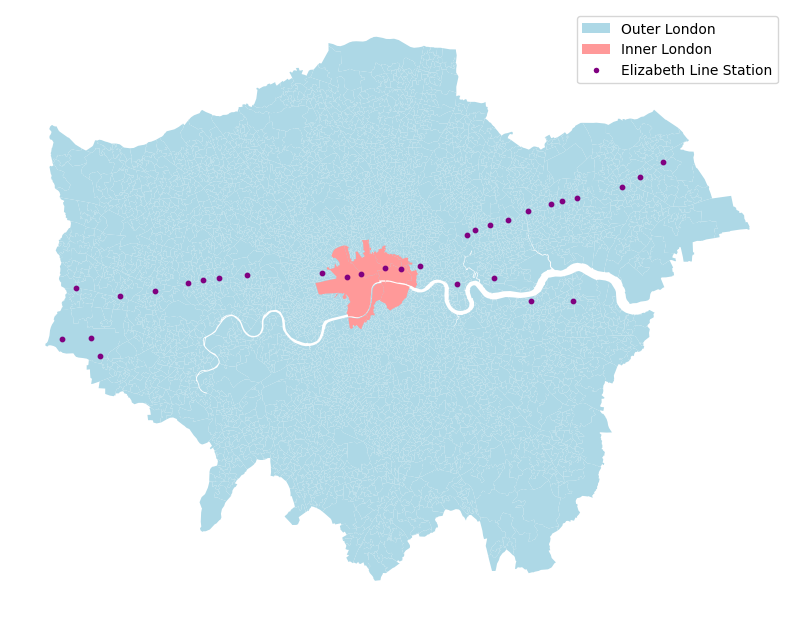

In [28]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 10))

lsoa.plot(ax=ax, color='#add8e6', linewidth=0)
caz.plot(ax=ax, color='#ff9999', linewidth=0, edgecolor='black')
crossrail_stations.plot(ax=ax, color='purple', markersize=10, label='Elizabeth Line Station')

ax.axis('off')

legend_elements = [
    Patch(facecolor='#add8e6', label='Outer London'),
    Patch(facecolor='#ff9999', label='Inner London'),
    Line2D([0], [0], marker='o', color='w', label='Elizabeth Line Station',
           markerfacecolor='purple', markersize=5)
]

ax.legend(handles=legend_elements, loc='upper right')
plt.show()

## **1.3 KI Jobs**

**Loading**

In [29]:
import glob
import pandas as pd

In [30]:
file_paths_bres_v2 = glob.glob('Data/BRES/*_V2.csv')
bres_v2_data_frames = {}
failed_files = {}

for file_path in file_paths_bres_v2:
    year = file_path.rsplit("/", 1)[-1].split("_", 1)[0]
    
    try:
        # Try reading with comma separator
        df = pd.read_csv(file_path, sep=',', engine='python', on_bad_lines='skip')
        
        # Remove columns that are completely NaN
        df = df.dropna(axis=1, how='all')

        # Attempt numeric conversion
        df = df.apply(pd.to_numeric, errors='ignore')

        # Count rows with any NaN
        n_with_nan = df.isna().any(axis=1).sum()
        print(f"{year}: {n_with_nan} rows with ≥1 NaN")

        # Drop those rows
        original_rows = len(df)
        df = df.dropna()
        dropped = original_rows - len(df)
        print(f"{year}: {dropped} rows dropped, {len(df)} rows kept")

        # Save cleaned data
        bres_v2_data_frames[year] = df

    except Exception as e:
        failed_files[year] = str(e)

print("\nYears loaded:", sorted(bres_v2_data_frames.keys()))
print("Years failed:", sorted(failed_files.keys()))

/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2022: 6 rows with ≥1 NaN
2022: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2014: 5 rows with ≥1 NaN
2014: 5 rows dropped, 4766 rows kept
2018: 6 rows with ≥1 NaN
2018: 6 rows dropped, 4835 rows kept
2020: 6 rows with ≥1 NaN
2020: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2016: 6 rows with ≥1 NaN
2016: 6 rows dropped, 4835 rows kept
2012: 5 rows with ≥1 NaN
2012: 5 rows dropped, 4766 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2010: 5 rows with ≥1 NaN
2010: 5 rows dropped, 4766 rows kept
2015: 6 rows with ≥1 NaN
2015: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2019: 6 rows with ≥1 NaN
2019: 6 rows dropped, 4835 rows kept
2023: 6 rows with ≥1 NaN
2023: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2009: 5 rows with ≥1 NaN
2009: 5 rows dropped, 4766 rows kept
2017: 6 rows with ≥1 NaN
2017: 6 rows dropped, 4835 rows kept


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


2021: 6 rows with ≥1 NaN
2021: 6 rows dropped, 4835 rows kept
2013: 5 rows with ≥1 NaN
2013: 5 rows dropped, 4766 rows kept
2011: 5 rows with ≥1 NaN
2011: 5 rows dropped, 4766 rows kept

Years loaded: ['2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
Years failed: []


/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')
/tmp/ipykernel_154/3079748608.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df = df.apply(pd.to_numeric, errors='ignore')


In [31]:
for year, df in bres_v2_data_frames.items():
    year_int = int(year)
    geo_key = 'LSOA01CD' if year_int <= 2014 else 'LSOA11CD'

    numeric_cols = [
        col for col in df.columns
        if col not in [geo_key, 'inner_outer'] 
        and pd.api.types.is_numeric_dtype(df[col])
        and not col.startswith('Unnamed')
    ]

    df['total'] = df[numeric_cols].sum(axis=1)
    bres_v2_data_frames[year] = df

In [32]:
bres_v2_2009 = bres_v2_data_frames["2009"]
bres_v2_2010 = bres_v2_data_frames["2010"]
bres_v2_2011 = bres_v2_data_frames["2011"]
bres_v2_2012 = bres_v2_data_frames["2012"]
bres_v2_2013 = bres_v2_data_frames["2013"]
bres_v2_2014 = bres_v2_data_frames["2014"]
bres_v2_2015 = bres_v2_data_frames["2015"]
bres_v2_2016 = bres_v2_data_frames["2016"]
bres_v2_2017 = bres_v2_data_frames["2017"]
bres_v2_2018 = bres_v2_data_frames["2018"]
bres_v2_2019 = bres_v2_data_frames["2019"]
bres_v2_2020 = bres_v2_data_frames["2020"]
bres_v2_2021 = bres_v2_data_frames["2021"]
bres_v2_2022 = bres_v2_data_frames["2022"]
bres_v2_2023 = bres_v2_data_frames["2023"]

In [33]:
from IPython.display import display

for year, df in sorted(bres_v2_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0



===== 2010 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,20.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,35.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0



===== 2011 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,20.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,45.0



===== 2012 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0



===== 2013 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0



===== 2014 =====
Shape: (4766, 19)
Dtypes:
 2001 super output areas - lower layer                                                      object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2001 super output areas - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,65.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0



===== 2015 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,40.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0



===== 2016 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,10.0,0.0,0.0,0.0,20.0



===== 2017 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0



===== 2018 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,65.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,15.0



===== 2019 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,10.0,50.0,0.0,0.0,10.0,0.0,0.0,0.0,95.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,20.0



===== 2020 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,5.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0



===== 2021 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,20.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,40.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0



===== 2022 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,10.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,35.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,35.0,65.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,10.0



===== 2023 =====
Shape: (4835, 19)
Dtypes:
 2011 super output area - lower layer                                                       object
mnemonic                                                                                   object
2110 : Manufacture of basic pharmaceutical products                                       float64
2120 : Manufacture of pharmaceutical preparations                                         float64
2620 : Manufacture of computers and peripheral equipment                                  float64
2651 : Manufacture of instruments and appliances for measuring, testing and navigation    float64
2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment        float64
2899 : Manufacture of other special-purpose machinery n.e.c.                              float64
3250 : Manufacture of medical and dental instruments and supplies                         float64
6201 : Computer programming activities                                   

,2011 super output area - lower layer,mnemonic,2110 : Manufacture of basic pharmaceutical products,2120 : Manufacture of pharmaceutical preparations,2620 : Manufacture of computers and peripheral equipment,"2651 : Manufacture of instruments and appliances for measuring, testing and navigation","2660 : Manufacture of irradiation, electromedical and electrotherapeutic equipment",2899 : Manufacture of other special-purpose machinery n.e.c.,3250 : Manufacture of medical and dental instruments and supplies,6201 : Computer programming activities,6202 : Computer consultancy activities,6209 : Other information technology and computer service activities,"6311 : Data processing, hosting and related activities",6312 : Web portals,7112 : Engineering activities and related technical consultancy,7120 : Technical testing and analysis,7211 : Research and experimental development on biotechnology,7219 : Other research and experimental development on natural sciences and engineering,total
0,Camden 001A,E01000907,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0
1,Camden 001B,E01000908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,30.0
2,Camden 001C,E01000909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,Camden 001D,E01000912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,65.0
4,Camden 001E,E01000913,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
years_1 = ['2009', '2010', '2011', '2012', '2013', '2014']

for year in years_1:
    df_1 = bres_v2_data_frames[f'bres_v2_{year}' if f'bres_v2_{year}' in bres_v2_data_frames else year]
    # Keep only relevant columns and rename
    df_1 = df_1[['mnemonic', 'total']].rename(columns={'mnemonic': '01cd'})
    # Save back
    bres_v2_data_frames[year] = df_1

In [35]:
years_2 = ['2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

for year in years_2:
    df_2 = bres_v2_data_frames[f'bres_v2_{year}' if f'bres_v2_{year}' in bres_v2_data_frames else year]
    # Keep only relevant columns and rename
    df_2 = df_2[['mnemonic', 'total']].rename(columns={'mnemonic': 'LSOA11CD'})
    # Save back
    bres_v2_data_frames[year] = df_2

In [36]:
bres_v2_2009 = bres_v2_data_frames["2009"]
bres_v2_2010 = bres_v2_data_frames["2010"]
bres_v2_2011 = bres_v2_data_frames["2011"]
bres_v2_2012 = bres_v2_data_frames["2012"]
bres_v2_2013 = bres_v2_data_frames["2013"]
bres_v2_2014 = bres_v2_data_frames["2014"]
bres_v2_2015 = bres_v2_data_frames["2015"]
bres_v2_2016 = bres_v2_data_frames["2016"]
bres_v2_2017 = bres_v2_data_frames["2017"]
bres_v2_2018 = bres_v2_data_frames["2018"]
bres_v2_2019 = bres_v2_data_frames["2019"]
bres_v2_2020 = bres_v2_data_frames["2020"]
bres_v2_2021 = bres_v2_data_frames["2021"]
bres_v2_2022 = bres_v2_data_frames["2022"]
bres_v2_2023 = bres_v2_data_frames["2023"]

In [37]:
from IPython.display import display

for year, df in sorted(bres_v2_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,15.0
2,E01000909,10.0
3,E01000912,10.0
4,E01000913,35.0



===== 2010 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,5.0
1,E01000908,20.0
2,E01000909,20.0
3,E01000912,10.0
4,E01000913,60.0



===== 2011 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,5.0
1,E01000908,15.0
2,E01000909,20.0
3,E01000912,15.0
4,E01000913,45.0



===== 2012 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,5.0
1,E01000908,5.0
2,E01000909,15.0
3,E01000912,15.0
4,E01000913,10.0



===== 2013 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,5.0
2,E01000909,10.0
3,E01000912,10.0
4,E01000913,5.0



===== 2014 =====
Shape: (4766, 2)
Dtypes:
 01cd      object
total    float64
dtype: object 

Head:


,01cd,total
0,E01000907,0.0
1,E01000908,15.0
2,E01000909,15.0
3,E01000912,65.0
4,E01000913,5.0



===== 2015 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,10.0
2,E01000909,15.0
3,E01000912,40.0
4,E01000913,15.0



===== 2016 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,10.0
2,E01000909,15.0
3,E01000912,30.0
4,E01000913,20.0



===== 2017 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,10.0
1,E01000908,10.0
2,E01000909,5.0
3,E01000912,55.0
4,E01000913,10.0



===== 2018 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,0.0
1,E01000908,5.0
2,E01000909,5.0
3,E01000912,65.0
4,E01000913,15.0



===== 2019 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,0.0
1,E01000908,15.0
2,E01000909,5.0
3,E01000912,95.0
4,E01000913,20.0



===== 2020 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,15.0
2,E01000909,5.0
3,E01000912,55.0
4,E01000913,10.0



===== 2021 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,20.0
2,E01000909,5.0
3,E01000912,40.0
4,E01000913,10.0



===== 2022 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,10.0
1,E01000908,35.0
2,E01000909,5.0
3,E01000912,65.0
4,E01000913,10.0



===== 2023 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,30.0
2,E01000909,10.0
3,E01000912,65.0
4,E01000913,0.0


**LSOA Look-Up**

In [38]:
lookup_path = 'Data/GIS/Lookup/Lower_Layer_Super_Output_Area_(2001)_to_Lower_Layer_Super_Output_Area_(2011)_to_Local_Authority_District_(2011)_Lookup_in_England_and_Wales.shp'
lookup = gpd.read_file(lookup_path)
lookup = lookup.to_crs(epsg=27700)

print("New CRS:", lookup.crs)

New CRS: EPSG:27700


In [39]:
lookup

,LSOA01CD,LSOA01NM,LSOA11CD,LSOA11NM,CHGIND,LAD11CD,LAD11NM,LAD11NMW,FID,geometry
0,E01031349,Adur 001A,E01031349,Adur 001A,U,E07000223,Adur,None,1,None
1,E01031350,Adur 001B,E01031350,Adur 001B,U,E07000223,Adur,None,2,None
2,E01031351,Adur 001C,E01031351,Adur 001C,U,E07000223,Adur,None,3,None
3,E01031352,Adur 001D,E01031352,Adur 001D,U,E07000223,Adur,None,4,None
4,E01031370,Adur 001E,E01031370,Adur 001E,U,E07000223,Adur,None,5,None
...,...,...,...,...,...,...,...,...,...,...
34912,E01013341,York 024B,E01013341,York 024B,U,E06000014,York,None,34913,None
34913,E01013342,York 024C,E01013342,York 024C,U,E06000014,York,None,34914,None
34914,E01013423,York 024D,E01013423,York 024D,U,E06000014,York,None,34915,None
34915,E01013424,York 024E,E01013424,York 024E,U,E06000014,York,None,34916,None


In [40]:
target_years = ['2009', '2010', '2011', '2012', '2013', '2014']

for year in target_years:
    print(f"\nProcessing {year}...")

    df = bres_v2_data_frames[year]

    # Merge with lookup
    merged = df.merge(
        lookup[['LSOA01CD', 'LSOA11CD']],
        left_on='01cd',
        right_on='LSOA01CD',
        how='left'
    )

    # Handle unmatched
    n_unmatched = merged['LSOA11CD'].isna().sum()
    print(f"{n_unmatched} unmatched codes in {year}")

    # Check for duplicates
    relevant_duplicates = merged.groupby('LSOA11CD').filter(lambda x: len(x) > 1)
    print(f"{relevant_duplicates['LSOA11CD'].nunique()} new codes appear more than once")

    # Drop unmatched rows
    merged = merged[~merged['LSOA11CD'].isna()].copy()

    # Replace 'mnemonic' with new code
    merged['01cd'] = merged['LSOA11CD']

    # Drop extra columns
    merged = merged.drop(columns=['LSOA01CD', 'LSOA11CD'])

    # Group by new code and average
    cleaned = (
        merged
        .groupby('01cd', as_index=False)[['total']]
        .mean()
        .rename(columns={'01cd': 'LSOA11CD'})
    )

    # Store cleaned data
    bres_v2_data_frames[year] = cleaned

print("\n All years processed with LSOA11CD as the geographic identifier.")


Processing 2009...
1 unmatched codes in 2009
15 new codes appear more than once

Processing 2010...
1 unmatched codes in 2010
15 new codes appear more than once

Processing 2011...
1 unmatched codes in 2011
15 new codes appear more than once

Processing 2012...
1 unmatched codes in 2012
15 new codes appear more than once

Processing 2013...
1 unmatched codes in 2013
15 new codes appear more than once

Processing 2014...
1 unmatched codes in 2014
15 new codes appear more than once

 All years processed with LSOA11CD as the geographic identifier.


In [41]:
for year, df in sorted(bres_v2_data_frames.items()):
    print(f"\n===== {year} =====")
    print("Shape:", df.shape)
    print("Dtypes:\n", df.dtypes, "\n")
    print("Head:")
    display(df.head())


===== 2009 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,125.0
1,E01000002,875.0
2,E01000003,65.0
3,E01000005,1215.0
4,E01000006,5.0



===== 2010 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,155.0
1,E01000002,1300.0
2,E01000003,70.0
3,E01000005,1890.0
4,E01000006,5.0



===== 2011 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,220.0
1,E01000002,1350.0
2,E01000003,90.0
3,E01000005,1440.0
4,E01000006,15.0



===== 2012 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,170.0
1,E01000002,1050.0
2,E01000003,65.0
3,E01000005,1485.0
4,E01000006,10.0



===== 2013 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,425.0
1,E01000002,1355.0
2,E01000003,65.0
3,E01000005,1575.0
4,E01000006,10.0



===== 2014 =====
Shape: (4834, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000001,535.0
1,E01000002,2075.0
2,E01000003,50.0
3,E01000005,1785.0
4,E01000006,10.0



===== 2015 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,10.0
2,E01000909,15.0
3,E01000912,40.0
4,E01000913,15.0



===== 2016 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,10.0
2,E01000909,15.0
3,E01000912,30.0
4,E01000913,20.0



===== 2017 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,10.0
1,E01000908,10.0
2,E01000909,5.0
3,E01000912,55.0
4,E01000913,10.0



===== 2018 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,0.0
1,E01000908,5.0
2,E01000909,5.0
3,E01000912,65.0
4,E01000913,15.0



===== 2019 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,0.0
1,E01000908,15.0
2,E01000909,5.0
3,E01000912,95.0
4,E01000913,20.0



===== 2020 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,15.0
2,E01000909,5.0
3,E01000912,55.0
4,E01000913,10.0



===== 2021 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,20.0
2,E01000909,5.0
3,E01000912,40.0
4,E01000913,10.0



===== 2022 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,10.0
1,E01000908,35.0
2,E01000909,5.0
3,E01000912,65.0
4,E01000913,10.0



===== 2023 =====
Shape: (4835, 2)
Dtypes:
 LSOA11CD     object
total       float64
dtype: object 

Head:


,LSOA11CD,total
0,E01000907,5.0
1,E01000908,30.0
2,E01000909,10.0
3,E01000912,65.0
4,E01000913,0.0


In [42]:
years_early = [str(y) for y in range(2009, 2015)]
years_late = [str(y) for y in range(2015, 2024)]

early_ids = set.intersection(*[set(bres_v2_data_frames[y]['LSOA11CD']) for y in years_early])
late_ids = set.intersection(*[set(bres_v2_data_frames[y]['LSOA11CD']) for y in years_late])

extra_in_late = late_ids - early_ids
print(f"\nLSOA11CDs in 2015–2023 but not in 2009–2014: {extra_in_late}")

if extra_in_late:
    row = bres_v2_data_frames['2015'][bres_v2_data_frames['2015']['LSOA11CD'].isin(extra_in_late)]
    print("\nRow in 2015:")
    print(row)


LSOA11CDs in 2015–2023 but not in 2009–2014: {'E01033730'}

Row in 2015:
       LSOA11CD  total
3467  E01033730   85.0


In [43]:
if extra_in_late:
    missing_id = list(extra_in_late)[0]
    is_absent_everywhere = all(
        missing_id not in set(bres_v2_data_frames[y]['LSOA11CD']) for y in years_early
    )

    if is_absent_everywhere:
        print(f"\n Dropping LSOA11CD {missing_id} from 2015–2023...")
        for y in years_late:
            df = bres_v2_data_frames[y]
            df = df[df['LSOA11CD'] != missing_id].copy()
            bres_v2_data_frames[y] = df
    else:
        print("\n The LSOA is not missing in all early years — no rows dropped.")


 Dropping LSOA11CD E01033730 from 2015–2023...


In [44]:
# Check LSOA21cD alignment across all years
final_ids_early = set.intersection(*[set(bres_v2_data_frames[y]['LSOA11CD']) for y in years_early])
final_ids_late = set.intersection(*[set(bres_v2_data_frames[y]['LSOA11CD']) for y in years_late])

# Compare
if final_ids_early == final_ids_late:
    print("\n All LSOA11CDs match across 2009–2014 and 2015–2023.")
else:
    diff1 = final_ids_early - final_ids_late
    diff2 = final_ids_late - final_ids_early
    print("\n Mismatch found:")
    print("In 2009–2014 but not in 2015–2023:", diff1)
    print("In 2015–2023 but not in 2009–2014:", diff2)


 All LSOA11CDs match across 2009–2014 and 2015–2023.


**Processing & Spatialising**

In [45]:
renamed_yearly_dfs = []

# Loop over each year
for year, df in bres_v2_data_frames.items():
    # Pad the year to 2-digit format (e.g. "09", "14", "23")
    suffix = year[-2:]
    
    df_renamed = df.rename(columns={
        'total': f'count_{suffix}'
    })

    df_renamed = df_renamed.set_index('LSOA11CD')

    renamed_yearly_dfs.append(df_renamed)

from functools import reduce

lsoa_ki = reduce(lambda left, right: left.join(right, how='outer'), renamed_yearly_dfs)
lsoa_ki = lsoa_ki.reset_index()

print(lsoa_ki.shape)
print(lsoa_ki.columns)

(4834, 16)
Index(['LSOA11CD', 'count_22', 'count_14', 'count_18', 'count_20', 'count_16',
       'count_12', 'count_10', 'count_15', 'count_19', 'count_23', 'count_09',
       'count_17', 'count_21', 'count_13', 'count_11'],
      dtype='object')


In [46]:
lsoa_ki

,LSOA11CD,count_22,count_14,count_18,count_20,count_16,count_12,count_10,count_15,count_19,count_23,count_09,count_17,count_21,count_13,count_11
0,E01000001,2010.0,535.0,795.0,790.0,835.0,170.0,155.0,695.0,1010.0,1970.0,125.0,835.0,1040.0,425.0,220.0
1,E01000002,3760.0,2075.0,2575.0,3005.0,1525.0,1050.0,1300.0,2140.0,3285.0,3085.0,875.0,2380.0,2675.0,1355.0,1350.0
2,E01000003,70.0,50.0,145.0,60.0,115.0,65.0,70.0,100.0,80.0,130.0,65.0,120.0,50.0,65.0,90.0
3,E01000005,2990.0,1785.0,1320.0,1815.0,1375.0,1485.0,1890.0,1605.0,2090.0,3840.0,1215.0,1535.0,1795.0,1575.0,1440.0
4,E01000006,0.0,10.0,15.0,5.0,10.0,10.0,5.0,10.0,15.0,0.0,5.0,10.0,0.0,10.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,E01033742,5.0,20.0,10.0,10.0,15.0,15.0,5.0,10.0,10.0,5.0,5.0,10.0,10.0,15.0,10.0
4830,E01033743,5.0,50.0,5.0,5.0,5.0,60.0,20.0,5.0,5.0,5.0,45.0,5.0,5.0,30.0,35.0
4831,E01033744,0.0,20.0,0.0,0.0,5.0,15.0,5.0,5.0,0.0,0.0,5.0,5.0,0.0,15.0,10.0
4832,E01033745,80.0,50.0,30.0,100.0,50.0,60.0,20.0,30.0,90.0,80.0,45.0,35.0,60.0,30.0,35.0


In [47]:
lsoa

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry,label,inner_outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.092 182011.23, 532162.491 181...",Outer London,1
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.813 181786.891, 532671.688 18...",Outer London,1
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,96,227.7,817,1.5,"POLYGON ((532135.145 182198.119, 532158.25 182...",Outer London,1
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,0,52.0,467,2.1,"POLYGON ((533807.946 180767.77, 533649.063 180...",Outer London,1
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,4,116.2,543,3.1,"POLYGON ((545122.049 184314.931, 545271.917 18...",Outer London,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4830,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,0,107.6,581,2.3,"POLYGON ((544642.68 179824.674, 544766.313 179...",Outer London,0
4831,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,0,20.4,663,3.1,"POLYGON ((546579.195 181097.813, 546687.036 18...",Outer London,0
4832,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,117,125.8,646,2.7,"POLYGON ((544536.486 179447.115, 544602.63 179...",Outer London,0
4833,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,0,32.3,591,3.1,"POLYGON ((546415.745 180152.27, 546320.715 180...",Outer London,0


In [48]:
lsoa_ki = lsoa.merge(
    lsoa_ki,
    on='LSOA11CD',
    how='right',
    suffixes=('', '_right')
)

unmatched = lsoa_ki[lsoa_ki['geometry'].isna()]
print(f"Unmatched LSOA11CDs from lsoa_ki not found in lsoa: {len(unmatched)}")
if not unmatched.empty:
    print("Example unmatched LSOA11CDs:")
    print(unmatched['LSOA11CD'].head())


ki_columns = lsoa_ki.columns.tolist()
ref_columns = ['LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'geometry', 'inner_outer']

# Combine and keep only these columns in final output
lsoa_ki = lsoa_ki[ki_columns + ref_columns]

print(f"\nFinal merged GeoDataFrame shape: {lsoa_ki.shape}")

Unmatched LSOA11CDs from lsoa_ki not found in lsoa: 0

Final merged GeoDataFrame shape: (4834, 39)


In [49]:
lsoa_ki

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,count_21,count_13,count_11,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,geometry,inner_outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,1040.0,425.0,220.0,City of London 001A,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532105.092 182011.23, 532162.491 181...",1
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,2675.0,1355.0,1350.0,City of London 001B,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532746.813 181786.891, 532671.688 18...",1
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,50.0,65.0,90.0,City of London 001C,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532135.145 182198.119, 532158.25 182...",1
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,1795.0,1575.0,1440.0,City of London 001E,E02000001,City of London 001,E09000001,City of London,"POLYGON ((533807.946 180767.77, 533649.063 180...",1
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.0,10.0,15.0,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,"POLYGON ((545122.049 184314.931, 545271.917 18...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,...,10.0,15.0,10.0,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,"POLYGON ((544642.68 179824.674, 544766.313 179...",0
4830,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,...,5.0,30.0,35.0,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,"POLYGON ((546579.195 181097.813, 546687.036 18...",0
4831,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,...,0.0,15.0,10.0,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,"POLYGON ((544536.486 179447.115, 544602.63 179...",0
4832,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,...,60.0,30.0,35.0,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,"POLYGON ((546415.745 180152.27, 546320.715 180...",0


## **1.4 Inner vs Outer**

In [50]:
lsoa_ki

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,count_21,count_13,count_11,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,geometry,inner_outer
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,1040.0,425.0,220.0,City of London 001A,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532105.092 182011.23, 532162.491 181...",1
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,2675.0,1355.0,1350.0,City of London 001B,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532746.813 181786.891, 532671.688 18...",1
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,50.0,65.0,90.0,City of London 001C,E02000001,City of London 001,E09000001,City of London,"POLYGON ((532135.145 182198.119, 532158.25 182...",1
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,1795.0,1575.0,1440.0,City of London 001E,E02000001,City of London 001,E09000001,City of London,"POLYGON ((533807.946 180767.77, 533649.063 180...",1
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.0,10.0,15.0,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,"POLYGON ((545122.049 184314.931, 545271.917 18...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,...,10.0,15.0,10.0,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,"POLYGON ((544642.68 179824.674, 544766.313 179...",0
4830,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,...,5.0,30.0,35.0,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,"POLYGON ((546579.195 181097.813, 546687.036 18...",0
4831,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,...,0.0,15.0,10.0,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,"POLYGON ((544536.486 179447.115, 544602.63 179...",0
4832,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,...,60.0,30.0,35.0,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,"POLYGON ((546415.745 180152.27, 546320.715 180...",0


In [51]:
print(lsoa_ki.columns.tolist())

['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry', 'label', 'inner_outer', 'count_22', 'count_14', 'count_18', 'count_20', 'count_16', 'count_12', 'count_10', 'count_15', 'count_19', 'count_23', 'count_09', 'count_17', 'count_21', 'count_13', 'count_11', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'geometry', 'inner_outer']


In [52]:
lsoa_ki = lsoa_ki.loc[:, ~lsoa_ki.columns.duplicated()]

In [53]:
print(lsoa_ki.columns.tolist())

['LSOA11CD', 'LSOA11NM', 'MSOA11CD', 'MSOA11NM', 'LAD11CD', 'LAD11NM', 'RGN11CD', 'RGN11NM', 'USUALRES', 'HHOLDRES', 'COMESTRES', 'POPDEN', 'HHOLDS', 'AVHHOLDSZ', 'geometry', 'label', 'inner_outer', 'count_22', 'count_14', 'count_18', 'count_20', 'count_16', 'count_12', 'count_10', 'count_15', 'count_19', 'count_23', 'count_09', 'count_17', 'count_21', 'count_13', 'count_11']


**Share**

In [54]:
count_cols = [col for col in lsoa_ki.columns if col.startswith("count_")]

for count_col in count_cols:
    year_suffix = count_col.split("_")[1]
    share_col = f"share_{year_suffix}"
    
    total_sum = lsoa_ki[count_col].sum()
    lsoa_ki[share_col] = lsoa_ki[count_col] / total_sum

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [55]:
lsoa_ki

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,share_12,share_10,share_15,share_19,share_23,share_09,share_17,share_21,share_13,share_11
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.000639,0.000567,0.002639,0.003005,0.004884,0.000560,0.002931,0.003241,0.001442,0.000767
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,0.003945,0.004758,0.008126,0.009775,0.007648,0.003919,0.008353,0.008337,0.004596,0.004707
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,0.000244,0.000256,0.000380,0.000238,0.000322,0.000291,0.000421,0.000156,0.000220,0.000314
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,0.005579,0.006918,0.006095,0.006219,0.009519,0.005441,0.005387,0.005594,0.005342,0.005021
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.000038,0.000018,0.000038,0.000045,0.000000,0.000022,0.000035,0.000000,0.000034,0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,...,0.000056,0.000018,0.000038,0.000030,0.000012,0.000022,0.000035,0.000031,0.000051,0.000035
4830,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,...,0.000225,0.000073,0.000019,0.000015,0.000012,0.000202,0.000018,0.000016,0.000102,0.000122
4831,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,...,0.000056,0.000018,0.000019,0.000000,0.000000,0.000022,0.000018,0.000000,0.000051,0.000035
4832,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,...,0.000225,0.000073,0.000114,0.000268,0.000198,0.000202,0.000123,0.000187,0.000102,0.000122


In [56]:
years = [f"{y:02}" for y in range(9, 24)]  # 2009–2014 as '09' to '14'
share_summary = []

for y in years:
    col = f'share_{y}'
    inner_total = lsoa_ki[lsoa_ki['inner_outer'] == 1][col].sum()
    outer_total = lsoa_ki[lsoa_ki['inner_outer'] == 0][col].sum()
    
    share_summary.append({
        'year': f"20{y}",
        'Inner London': inner_total * 100,
        'Outer London': outer_total * 100
    })

share_df = pd.DataFrame(share_summary)

In [57]:
share_df

,year,Inner London,Outer London
0,2009,49.385881,50.614119
1,2010,46.069241,53.930759
2,2011,45.736650,54.263350
3,2012,47.344347,52.655653
4,2013,47.994234,52.005766
5,2014,48.038360,51.961640
6,2015,48.186755,51.813245
7,2016,45.137007,54.862993
8,2017,45.933946,54.066054
9,2018,47.892001,52.107999


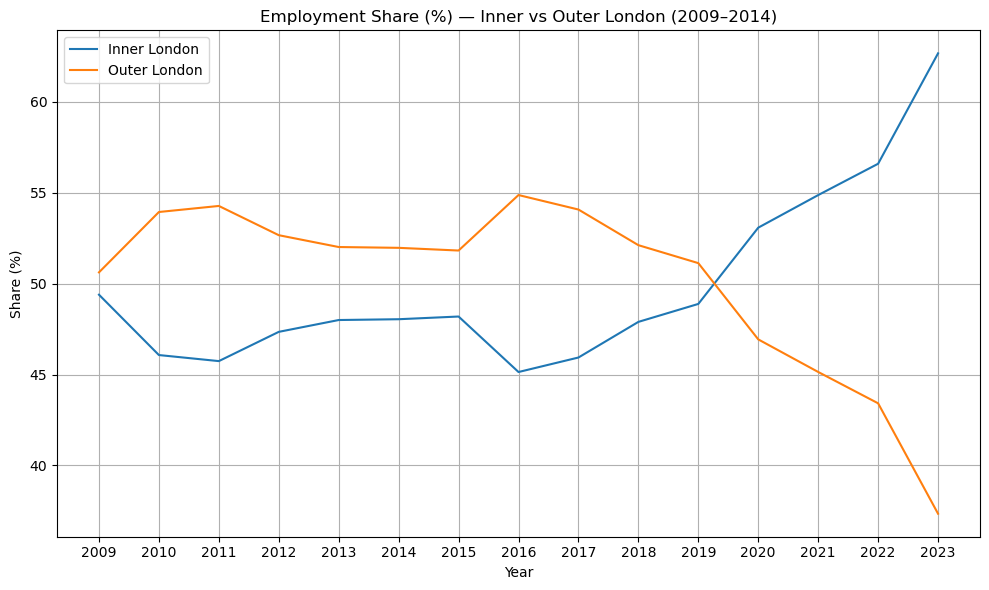

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(share_df['year'], share_df['Inner London'], label='Inner London')
plt.plot(share_df['year'], share_df['Outer London'], label='Outer London')

plt.title("Employment Share (%) — Inner vs Outer London (2009–2014)")
plt.xlabel("Year")
plt.ylabel("Share (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Count**

In [59]:
count_summary = []

for y in years:
    col = f'count_{y}'
    inner_total = lsoa_ki[lsoa_ki['inner_outer'] == 1][col].sum()
    outer_total = lsoa_ki[lsoa_ki['inner_outer'] == 0][col].sum()
    
    count_summary.append({
        'year': f"20{y}",
        'Inner London': inner_total,
        'Outer London': outer_total
    })

count_df = pd.DataFrame(count_summary)

In [60]:
count_df

,year,Inner London,Outer London
0,2009,110272.5,113015.00
1,2010,125867.5,147346.25
2,2011,131175.0,155630.00
3,2012,126020.0,140157.50
4,2013,141490.0,153316.25
5,2014,152030.0,164446.25
6,2015,126895.0,136445.00
7,2016,139110.0,169085.00
8,2017,130875.0,154045.00
9,2018,142790.0,155360.00


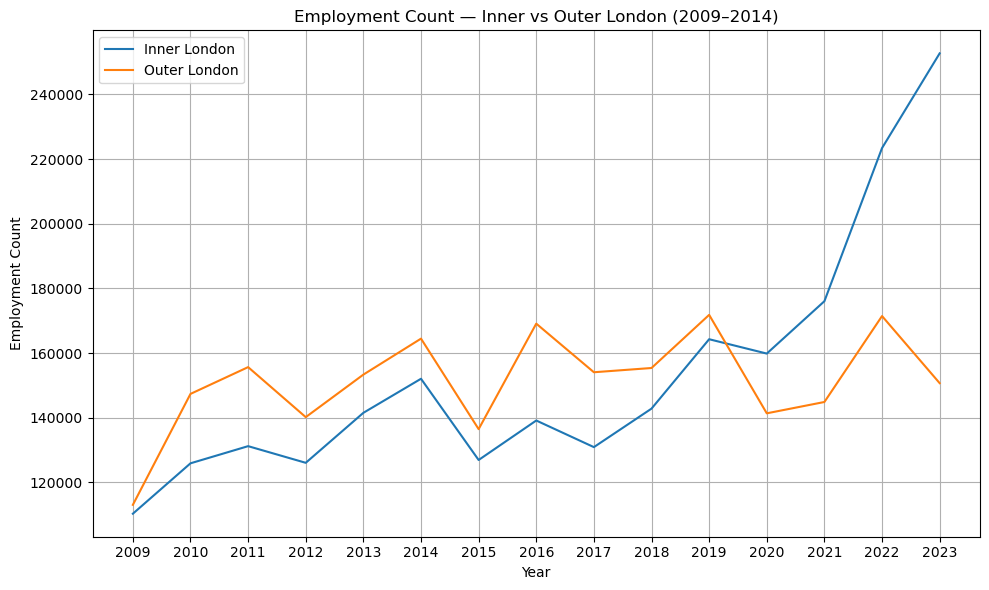

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(count_df['year'], count_df['Inner London'], label='Inner London')
plt.plot(count_df['year'], count_df['Outer London'], label='Outer London')

plt.title("Employment Count — Inner vs Outer London (2009–2014)")
plt.xlabel("Year")
plt.ylabel("Employment Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [90]:
count_summary = []

for y in years:
    col = f'count_{y}'
    inner_total = lsoa_ki[lsoa_ki['inner_outer'] == 1][col].sum()
    outer_total = lsoa_ki[lsoa_ki['inner_outer'] == 0][col].sum()
    all_total = inner_total + outer_total  # Total for London

    count_summary.append({
        'year': f"20{y}",
        'Inner London': inner_total,
        'Outer London': outer_total,
        'All London': all_total
    })

count_df = pd.DataFrame(count_summary)

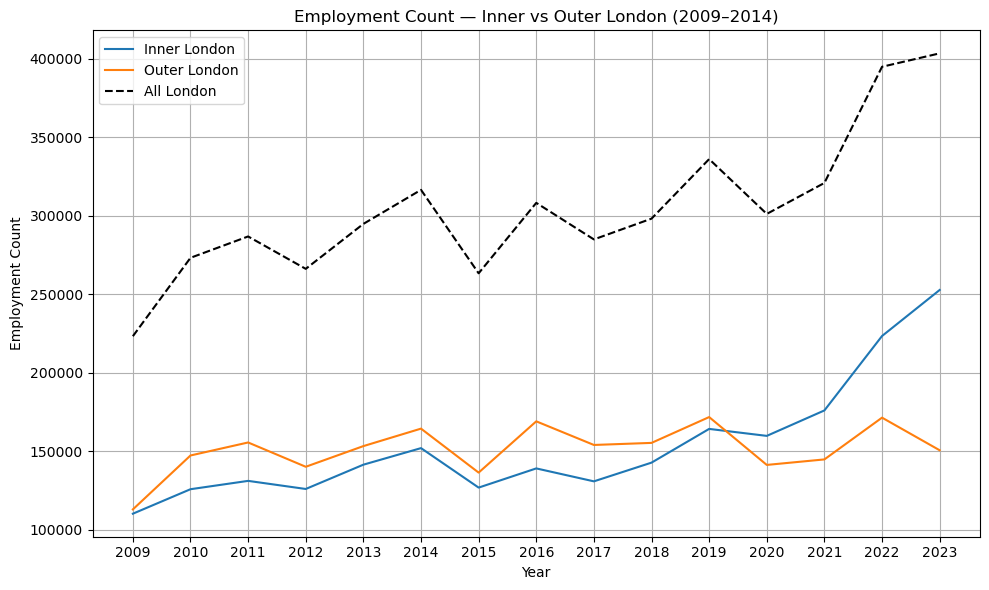

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(count_df['year'], count_df['Inner London'], label='Inner London')
plt.plot(count_df['year'], count_df['Outer London'], label='Outer London')
plt.plot(count_df['year'], count_df['All London'], label='All London', linestyle='--', color='black')

plt.title("Employment Count — Inner vs Outer London (2009–2014)")
plt.xlabel("Year")
plt.ylabel("Employment Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Distance Cut-off**

**Preparation**

In [62]:
lsoa_ki

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,share_12,share_10,share_15,share_19,share_23,share_09,share_17,share_21,share_13,share_11
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,...,0.000639,0.000567,0.002639,0.003005,0.004884,0.000560,0.002931,0.003241,0.001442,0.000767
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,...,0.003945,0.004758,0.008126,0.009775,0.007648,0.003919,0.008353,0.008337,0.004596,0.004707
2,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,E12000007,London,1346,1250,...,0.000244,0.000256,0.000380,0.000238,0.000322,0.000291,0.000421,0.000156,0.000220,0.000314
3,E01000005,City of London 001E,E02000001,City of London 001,E09000001,City of London,E12000007,London,985,985,...,0.005579,0.006918,0.006095,0.006219,0.009519,0.005441,0.005387,0.005594,0.005342,0.005021
4,E01000006,Barking and Dagenham 016A,E02000017,Barking and Dagenham 016,E09000002,Barking and Dagenham,E12000007,London,1703,1699,...,0.000038,0.000018,0.000038,0.000045,0.000000,0.000022,0.000035,0.000000,0.000034,0.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4829,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1352,1352,...,0.000056,0.000018,0.000038,0.000030,0.000012,0.000022,0.000035,0.000031,0.000051,0.000035
4830,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,2038,2038,...,0.000225,0.000073,0.000019,0.000015,0.000012,0.000202,0.000018,0.000016,0.000102,0.000122
4831,E01033744,Greenwich 007G,E02000319,Greenwich 007,E09000011,Greenwich,E12000007,London,1845,1728,...,0.000056,0.000018,0.000019,0.000000,0.000000,0.000022,0.000018,0.000000,0.000051,0.000035
4832,E01033745,Greenwich 002I,E02000314,Greenwich 002,E09000011,Greenwich,E12000007,London,1820,1820,...,0.000225,0.000073,0.000114,0.000268,0.000198,0.000202,0.000123,0.000187,0.000102,0.000122


In [63]:
lsoa_ki.to_csv('lsoa_ki.csv', index=False)

In [64]:
crossrail_stations = crossrail_stations.to_crs(caz.crs)

from shapely.ops import unary_union
caz_union = unary_union(caz.geometry)

crossrail_stations['inner_outer'] = crossrail_stations.geometry.within(caz_union).astype(int)

In [65]:
crossrail_stations

,id,name,nlc_id,lines,cartography,altmodeid,alt_id,altmodeid2,zone,geometry,parsed_lines,inner_outer
107,940GZZLUHR4,Heathrow Terminal 4,0781,"[ { ""name"": ""Piccadilly"" }, { ""name"": ""Crossra...","{ ""labelX"": 30, ""labelY"": 40, ""display_name"": ...",None,118,None,6,POINT (508099.649 174443.721),"[{'name': 'Piccadilly'}, {'name': 'Crossrail',...",0
108,940GZZLUHR5,Heathrow Terminal 5,0783,"[ { ""name"": ""Piccadilly"", ""opened"": 2008, ""nig...","{ ""labelX"": -30 }",None,306,None,6,POINT (504964.605 175923.233),"[{'name': 'Piccadilly', 'opened': 2008, 'night...",0
109,940GZZLUHRC,Heathrow Terminals 2 & 3,0780,"[ { ""name"": ""Piccadilly"", ""nightopened"": 2016 ...","{ ""labelX"": -1, ""labelY"": -50 }",None,119,None,6,POINT (507402.598 175969.334),"[{'name': 'Piccadilly', 'nightopened': 2016}, ...",0
363,910GABWD,Abbey Wood,5131,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": 30 }",None,None,None,4,POINT (547303.348 179036.54),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",0
365,910GACTONML,Acton Main Line,3000,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 1, ""labelY"": 45 }",None,None,None,3,POINT (520330.93 181221.303),"[{'name': 'Crossrail', 'opened': 2018}]",0
373,910GBONDST,Bond Street,None,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": -1, ""labelY"": 45, ""display_name"": ...",None,None,None,1,POINT (528608.351 181011.44),"[{'name': 'Crossrail', 'opened': 2018}]",1
386,910GCHDWLHT,Chadwell Heath,6874,"[ { ""name"": ""TfL Rail"", ""opened"": 2015, ""close...","{ ""labelX"": 1, ""labelY"": 45 }",None,None,None,5,POINT (547655.515 187599.145),"[{'name': 'TfL Rail', 'opened': 2015, 'closed'...",0
401,910GCUSTMHS,Custom House,6964,"[ { ""name"": ""Crossrail"", ""opened"": 2018 } ]","{ ""labelX"": 1, ""labelY"": -45, ""display_name"": ...",None,None,None,3,POINT (540740.623 180943.552),"[{'name': 'Crossrail', 'opened': 2018}]",0
405,910GEALINGB,Ealing Broadway,3190,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": -1, ""labelY"": -55, ""display_name"":...",None,EAL,None,3,POINT (517951.045 180907.103),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",0
414,910GFNTLSR,Farringdon,9509,"[ { ""name"": ""Crossrail"", ""opened"": 2018 }, { ""...","{ ""labelX"": -25, ""labelY"": -20, ""display_name""...",None,ZFD,None,1,POINT (531693.139 181735.827),"[{'name': 'Crossrail', 'opened': 2018}, {'name...",1


In [66]:
lsoa_outer = lsoa_ki[lsoa_ki['inner_outer'] == 0]
lsoa_outer['centroid'] = lsoa_outer.geometry.centroid

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [67]:
crossrail_outer = crossrail_stations[crossrail_stations['inner_outer'] == 0]

In [68]:
lsoa_outer = lsoa_outer.to_crs(crossrail_outer.crs)

# Calculate minimum distance from each LSOA to any Crossrail station
lsoa_outer['distance_to_EL'] = lsoa_outer['centroid'].apply(
    lambda point: crossrail_outer.geometry.distance(point).min()
)

**(1) Change in Share vs Distance**

In [80]:
# Create bins 
bin_edges = list(range(0, 3200, 100))  
lsoa_outer['distance_bin'] = pd.cut(lsoa_outer['distance_to_EL'], bins=bin_edges)

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [81]:
bin_avg = lsoa_outer.groupby('distance_bin')[['share_09', 'share_23']].mean().reset_index()

/tmp/ipykernel_154/1839831632.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = lsoa_outer.groupby('distance_bin')[['share_09', 'share_23']].mean().reset_index()


In [82]:
bin_avg['bin_mid'] = bin_avg['distance_bin'].apply(lambda x: x.mid if pd.notnull(x) else None)
bin_avg['gap'] = bin_avg['share_23'] - bin_avg['share_09']

max_gap_row = bin_avg.loc[bin_avg['gap'].abs().idxmax()]

cutoff_mid = max_gap_row['bin_mid']
cutoff_gap = max_gap_row['gap']

print(f"Maximum gap: {cutoff_gap:.5f} at distance: {cutoff_mid} meters")

Maximum gap: 0.00063 at distance: 150.0 meters


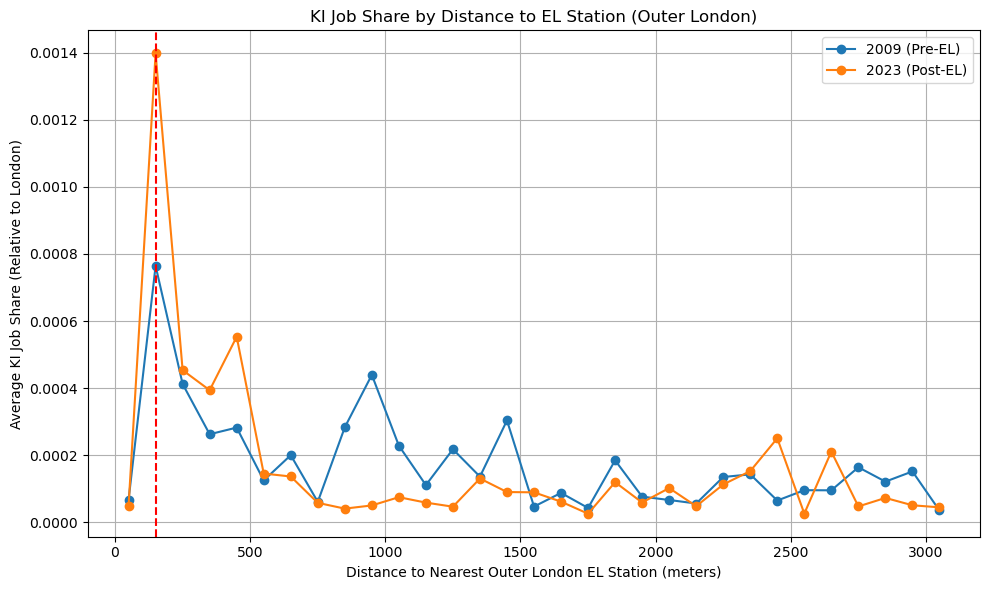

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(bin_avg['bin_mid'], bin_avg['share_09'], label='2009 (Pre-EL)', marker='o')
plt.plot(bin_avg['bin_mid'], bin_avg['share_23'], label='2023 (Post-EL)', marker='o')

plt.axvline(cutoff_mid, color='red', linestyle='--')
plt.xlabel('Distance to Nearest Outer London EL Station (meters)')
plt.ylabel('Average KI Job Share (Relative to London)')
plt.title('KI Job Share by Distance to EL Station (Outer London)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**(2) Change in Count vs Distance**

In [85]:
bin_avg = lsoa_outer.groupby('distance_bin')[['count_09', 'count_23']].mean().reset_index()

/tmp/ipykernel_154/3914750140.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_avg = lsoa_outer.groupby('distance_bin')[['count_09', 'count_23']].mean().reset_index()


In [86]:
bin_avg['bin_mid'] = bin_avg['distance_bin'].apply(lambda x: x.mid if pd.notnull(x) else None)
bin_avg['gap'] = bin_avg['count_23'] - bin_avg['count_09']

max_gap_row = bin_avg.loc[bin_avg['gap'].abs().idxmax()]

cutoff_mid = max_gap_row['bin_mid']
cutoff_gap = max_gap_row['gap']

print(f"Maximum gap: {cutoff_gap:.5f} at distance: {cutoff_mid} meters")

Maximum gap: 393.12500 at distance: 150.0 meters


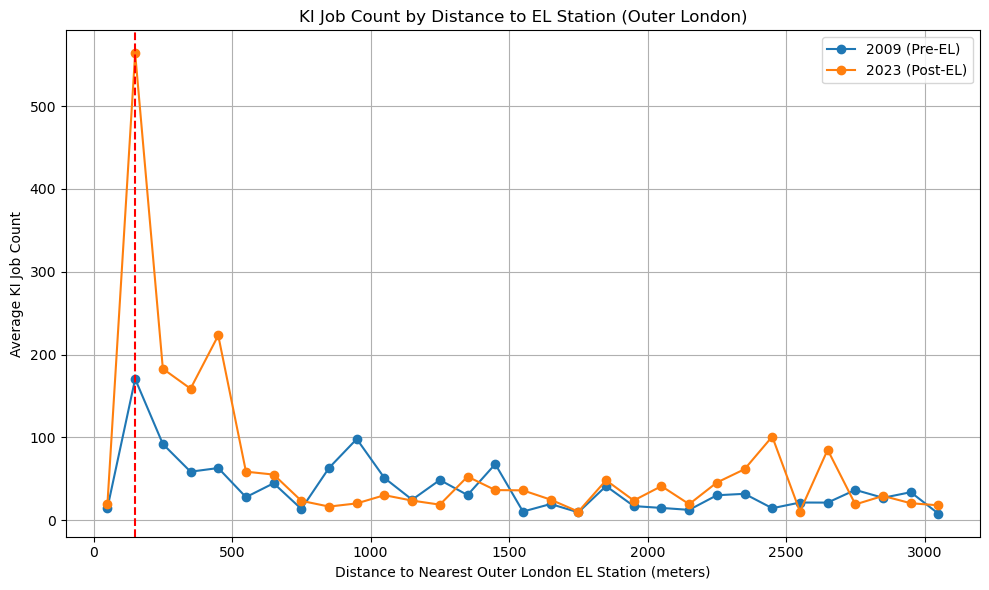

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(bin_avg['bin_mid'], bin_avg['count_09'], label='2009 (Pre-EL)', marker='o')
plt.plot(bin_avg['bin_mid'], bin_avg['count_23'], label='2023 (Post-EL)', marker='o')

plt.axvline(cutoff_mid, color='red', linestyle='--')
plt.xlabel('Distance to Nearest Outer London EL Station (meters)')
plt.ylabel('Average KI Job Count')
plt.title('KI Job Count by Distance to EL Station (Outer London)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**(3) Share in Distance-based Bins Panel**

In [73]:
# Step 1: Work with a copy of outer LSOAs
lsoa_outer = lsoa_ki[lsoa_ki['inner_outer'] == 0].copy()

# Step 2: Align CRS
lsoa_outer = lsoa_outer.to_crs(crossrail_stations.crs)

# Step 3: Compute centroids
lsoa_outer['centroid'] = lsoa_outer.geometry.centroid

# Step 4: Filter outer Crossrail stations
crossrail_outer = crossrail_stations[crossrail_stations['inner_outer'] == 0].copy()

# Step 5: Compute min distance from each LSOA centroid to any Crossrail station
lsoa_outer['distance_to_EL'] = lsoa_outer['centroid'].apply(
    lambda point: crossrail_outer.geometry.distance(point).min()
)

# ✅ Step 6: Store distances back into main lsoa_ki by index
lsoa_ki.loc[lsoa_outer.index, 'distance_to_EL'] = lsoa_outer['distance_to_EL']

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_154/738563138.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = long_df.groupby(['year', 'distance_bin'])['share'].mean().reset_index()


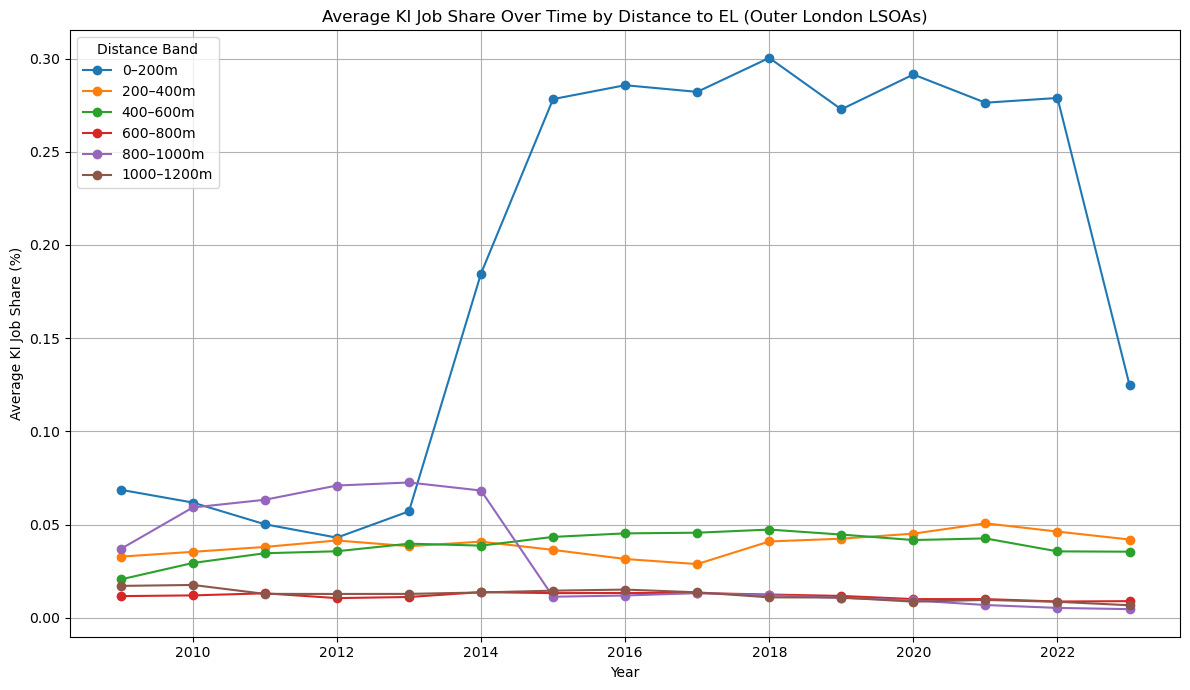

In [74]:
# Define distance bins
bin_edges = [0, 200, 400, 600, 800, 1000, 1200]
lsoa_outer = lsoa_ki[lsoa_ki['inner_outer'] == 0]
lsoa_outer['distance_bin'] = pd.cut(lsoa_outer['distance_to_EL'], bins=bin_edges)

# Identify share columns across years
share_cols = [col for col in lsoa_outer.columns if col.startswith('share_')]
share_cols = sorted(share_cols)  # Ensure chronological order

# Melt to long format for easy plotting
long_df = lsoa_outer[['distance_bin'] + share_cols].melt(
    id_vars='distance_bin',
    value_vars=share_cols,
    var_name='year',
    value_name='share'
)

# Convert year column to actual year integers (e.g., "share_09" → 2009)
long_df['year'] = long_df['year'].str.extract(r'share_(\d+)')[0].astype(int)
long_df['year'] += 2000

# Group by year and distance bin, then take the mean share
summary = long_df.groupby(['year', 'distance_bin'])['share'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))

for band in summary['distance_bin'].dropna().unique():
    band_data = summary[summary['distance_bin'] == band]
    plt.plot(band_data['year'], band_data['share'] * 100, marker='o', label=f"{int(band.left)}–{int(band.right)}m")

plt.xlabel("Year")
plt.ylabel("Average KI Job Share (%)")
plt.title("Average KI Job Share Over Time by Distance to EL (Outer London LSOAs)")
plt.grid(True)
plt.legend(title='Distance Band')
plt.tight_layout()
plt.show()

**(4) Count in Distance-based Bins Panel**

/opt/conda/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/tmp/ipykernel_154/1672215898.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = long_df.groupby(['year', 'distance_bin'])['count'].mean().reset_index()


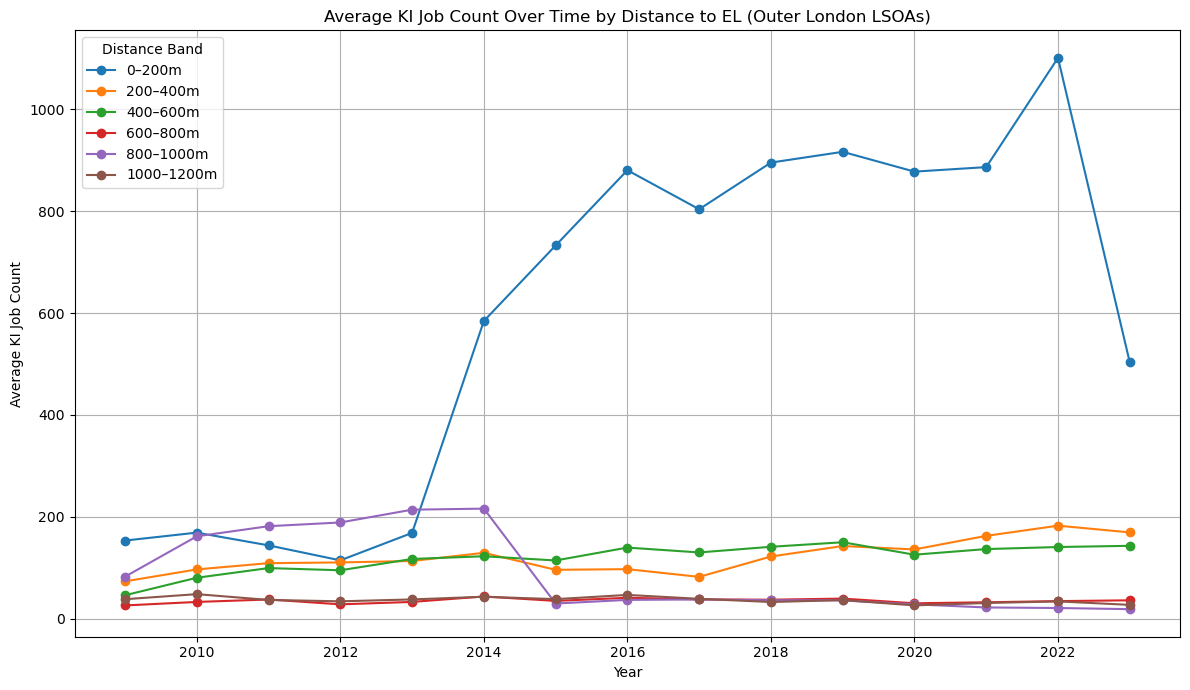

In [89]:
# Define distance bins
bin_edges = [0, 200, 400, 600, 800, 1000, 1200]
lsoa_outer = lsoa_ki[lsoa_ki['inner_outer'] == 0]
lsoa_outer['distance_bin'] = pd.cut(lsoa_outer['distance_to_EL'], bins=bin_edges)

# Identify share columns across years
count_cols = [col for col in lsoa_outer.columns if col.startswith('count_')]
count_cols = sorted(count_cols)  # Ensure chronological order

# Melt to long format for easy plotting
long_df = lsoa_outer[['distance_bin'] + count_cols].melt(
    id_vars='distance_bin',
    value_vars=count_cols,
    var_name='year',
    value_name='count'
)

# Convert year column to actual year integers (e.g., "share_09" → 2009)
long_df['year'] = long_df['year'].str.extract(r'count_(\d+)')[0].astype(int)
long_df['year'] += 2000

# Group by year and distance bin, then take the mean share
summary = long_df.groupby(['year', 'distance_bin'])['count'].mean().reset_index()

# Plot
plt.figure(figsize=(12, 7))

for band in summary['distance_bin'].dropna().unique():
    band_data = summary[summary['distance_bin'] == band]
    plt.plot(band_data['year'], band_data['count'], marker='o', label=f"{int(band.left)}–{int(band.right)}m")

plt.xlabel("Year")
plt.ylabel("Average KI Job Count")
plt.title("Average KI Job Count Over Time by Distance to EL (Outer London LSOAs)")
plt.grid(True)
plt.legend(title='Distance Band')
plt.tight_layout()
plt.show()

In [96]:
near = lsoa_outer[lsoa_outer['distance_to_EL'] <= 500]
far = lsoa_outer[lsoa_outer['distance_to_EL'] > 500]

net_change_df = pd.DataFrame({
    'Outer LSOA Group': ['Near EL (<500m)', 'Far from EL (>500m)'],
    'Net Change (Count)': [
        near['count_23'].sum() - near['count_09'].sum(),
        far['count_23'].sum() - far['count_09'].sum()
    ],
    'Net Change (Share)': [
        near['share_23'].sum() - near['share_09'].sum(),
        far['share_23'].sum() - far['share_09'].sum()
    ]
})
display(net_change_df)

,Outer LSOA Group,Net Change (Count),Net Change (Share)
0,Near EL (<500m),13302.5,0.019464
1,Far from EL (>500m),24352.5,-0.152101
